### Modules
- 🔌 load_ext: conecta módulos automaticamente
- 🔁 autoreload 2: actualiza resultados de load_ext a cada celda

In [2]:
%load_ext autoreload 
%autoreload 2 

### RootPath: Set Working Directory to Project Root


In [3]:
from pathlib import Path
import os

class RootPath:
    def __init__(self, marker=".here", root="."):
        self.root = self.resolve(Path(root), marker)
        print(f"Now you are here: {self.root}")

    def resolve(self, start_path: Path, marker: str) -> str:
        search_path = start_path.resolve()
        for directory in [search_path] + list(search_path.parents):
            marker_path = directory / marker
            if marker_path.exists():
                return str(directory)

        raise FileNotFoundError(
            f"Marker file '{marker}' not found.\n"
            f"Please create a '{marker}' file at the project root.\n"
            f"Search started from: {search_path}\n"
        )

    def __str__(self):
        return self.root

# Create instance -> finds the project root
project_root = RootPath()
root_path = Path(str(project_root))

# Change the current working directory to the project root
os.chdir(root_path)

# Confirm current working directory
print("Current working directory:", Path.cwd())


Now you are here: /home/jayrd/wks-git/data_science_portfolio/ds_missing_data
Current working directory: /home/jayrd/wks-git/data_science_portfolio/ds_missing_data


In [4]:
import pandas as pd
import numpy as np

# Implementations
from src.core.implementations.sample_run import SampleDF
from src.core.implementations.correlation_columns_run import CorrColumns
from src.core.implementations.corr_filterproxy_run import CorrFilterProxy
from src.core.implementations.corr_plotter_run import CorrPlotter
import src.core.implementations.null_report_run #missing accesor Implt


>>> registering accessor 'missing'


#### Load data with pre-normalization for missing values

In [5]:
# Build the file path in a way that works across different operating systems
csv_path_ocean = os.path.join(os.getcwd(), "data", "ocean.csv")

common_na_strings = [
    "missing", "NA", "N A", "N/A", "#N/A", "NA ", " NA", "N /A", "N / A", " N / A",
    "N / A ", "na", "n a", "n/a", "na ", " na", "n /a", "n / a", " a / a", "n / a ",
    "NULL", "null", "", "?", "*", "."
]
common_na_numbers = [-9, -99, -999, -9999, 9999, 66, 77, 88, -1]

df_original = pd.read_csv(csv_path_ocean, na_filter=True, na_values=common_na_numbers+common_na_strings)
df_original = df_original.iloc[:, 1:] #Elimina columna Unnamed: 0'
df = df_original.copy(deep=True)


### Summary table for missing data overview

In [6]:
summary_table = df.missing.summary()
summary_table


,variable,n_missing,missing_flag,n_cases,n_unique,most_common_value,pct_missing,dtype
0,year,0,0,736,2,1997.000000,0.000000,float64
1,latitude,0,0,736,3,0.000000,0.000000,float64
2,longitude,0,0,736,2,-110.000000,0.000000,float64
3,sea_temp_c,3,1,736,417,27.600000,0.407609,float64
4,air_temp_c,81,1,736,307,27.780001,11.005435,float64
5,humidity,102,1,736,164,87.500000,13.858696,float64
6,wind_ew,5,1,736,98,-4.400000,0.679348,float64
7,wind_ns,2,1,736,105,4.100000,0.271739,float64


### DataFrame with random sample

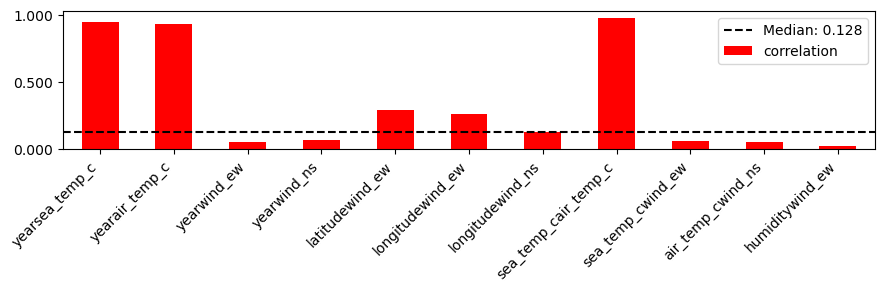

In [7]:
# Generate a DataFrame with pairwise correlations
df_correlations = CorrColumns(df=df).correlate_pairs()

# Proxy class to validate and prepare the data for the plotter
# Apply a minimum correlation filter (e.g., 0.50 = only correlations > 50%) pct_filter_col=0.50
proxy = CorrFilterProxy(df=df_correlations)
df_filtered = proxy.filter(pct_filter_col=0.50)  

# Plot correlations
plotter = CorrPlotter(df=df_filtered)
df_top = plotter.plot(color="red", show_median=True)



### DataFrame with random sample

In [8]:
"""
    Utility class to work with sample DataFrames.

    Behavior:
    - If only_sample=True → returns a sample DataFrame.
    - If only_sample=False → randomly checks values from each column 
      to ensure they match the declared dtype.
"""
df_sample = SampleDF(df=df, pct=0.5, only_sample=True).sample_dtype()
df_sample.sort_values(by="sea_temp_c", ascending=True)


,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
487,1993.0,0.0,-95.0,21.799999,21.730000,NaN,-1.8,2.7
473,1993.0,0.0,-95.0,21.860001,21.850000,NaN,-3.2,3.6
469,1993.0,0.0,-95.0,21.940001,21.969999,NaN,-0.8,4.8
470,1993.0,0.0,-95.0,21.969999,21.809999,NaN,-2.2,4.3
571,1993.0,-2.0,-95.0,21.990000,22.430000,85.199997,-3.5,5.2
...,...,...,...,...,...,...,...,...
178,1997.0,0.0,-95.0,29.559999,NaN,79.099998,-2.3,0.4
177,1997.0,0.0,-95.0,29.629999,NaN,76.300003,-0.4,-3.9
174,1997.0,0.0,-95.0,29.889999,NaN,74.500000,-3.0,-0.2
176,1997.0,0.0,-95.0,29.950001,NaN,78.000000,0.9,-4.0
